# Metody Obliczeniowe w Nauce i Technice Laboratorium 9
## Zastosowania DFT
### Paweł Gorgolewski

In [35]:
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import os
from collections import defaultdict

## 1. Analiza obrazów

1. Wczytaj obraz przedstawiajacy tekst, dokonaj odwrócenia kolorów (czarne tło), a
nastepnie jego transformacji do domeny czestotliwosciowej za pomoca DFT. Przedstaw
wartosci fazy i modułu współczynników Fouriera (osobno).
2. Wybierz przykładowego reprezentanta grupy - wytnij z duzego zdjecia wzorzec
obiektu np. litere e lub charakterystyczny fragment ryby z ławicy (imcrop).
3. Wykorzystujac transformacje Fouriera oblicz korelacje miedzy wybranym wzorcem,
a całym obrazem.
4. Przedstaw otrzymany obraz wyjsciowy oraz punkty, w których wykryto wystapienie
wzorca (nałóz je na obraz oryginalny).
5. Znajdz liczbe wystapien wzorca. Testy przeprowadz na dwóch zbiorach danych.

In [36]:
def process_img(img, extra_val_tranform=None): #img is result of Image.open()
    gray_scale = img.convert('L')
    inverted = ImageOps.invert(gray_scale)
    transformed = np.abs(np.array(inverted) - extra_val_tranform) if extra_val_tranform is not None else np.array(inverted)
    return img, np.swapaxes(transformed, 0, 1)

def show_image(img, subplot_indexes, title, img_swapaxes=True, fun_before_show=None):
    img = np.swapaxes(np.array(img), 0, 1) if img_swapaxes else img
    img = fun_before_show(img) if fun_before_show is not None else img
    ax = plt.subplot(*subplot_indexes)
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

def find_patterns(original_image, pattern_image, min_val, extra_val_tranform=None, rgb_diffs=(-50,-80,50), show_processed=False):
    def prepare_img(img_path):
        img = Image.open(img_path)
        return process_img(img, extra_val_tranform)

    img, img_prepared = prepare_img(original_image)
    pattern_img, pattern_prepared = prepare_img(pattern_image)

    width, height = img.size
    dft = np.fft.fft2(img_prepared)

    size = (20,20) if show_processed else (10,10)
    fig = plt.figure(figsize=size)
    fig.tight_layout()

    subplots_idx = [(4,2,1), (4,2,2), (4,2,3), (4,2,4), (4,2,(5,8))] if show_processed else [(3,2,1), (3,2,2), (3,2,(3,6))]
    show_image(dft, subplots_idx[0], "Phase", True, lambda im: np.angle(im))
    show_image(dft, subplots_idx[1], "Amplitude", True, lambda im: np.log(abs(im)))

    if show_processed:
        show_image(img_prepared, subplots_idx[2], "Processed image", True)
        show_image(pattern_prepared, subplots_idx[3], "Processed pattern", True)

    C = np.real(np.fft.ifft2(np.multiply(dft, np.fft.fft2(np.rot90(pattern_prepared, 2), s=(width, height)))))
    C_min_v = min_val * (np.max(C) - np.min(C)) + np.min(C)

    pattern_width, pattern_height = pattern_img.size
    img_comp = img.load()
    for x, y in np.argwhere(C >= C_min_v):
        for pw in range(pattern_width):
            for ph in range(pattern_height):
                r, g, b = img_comp[x-pw, y-ph]
                diff_r, diff_g, diff_b = rgb_diffs
                img_comp[x-pw, y-ph] = (r+diff_r, g+diff_g, b+diff_b)

    show_image(img, subplots_idx[-1], f'{len(np.argwhere(C >= C_min_v))} OCCURRENCES', False)
    plt.show()

### Ławica

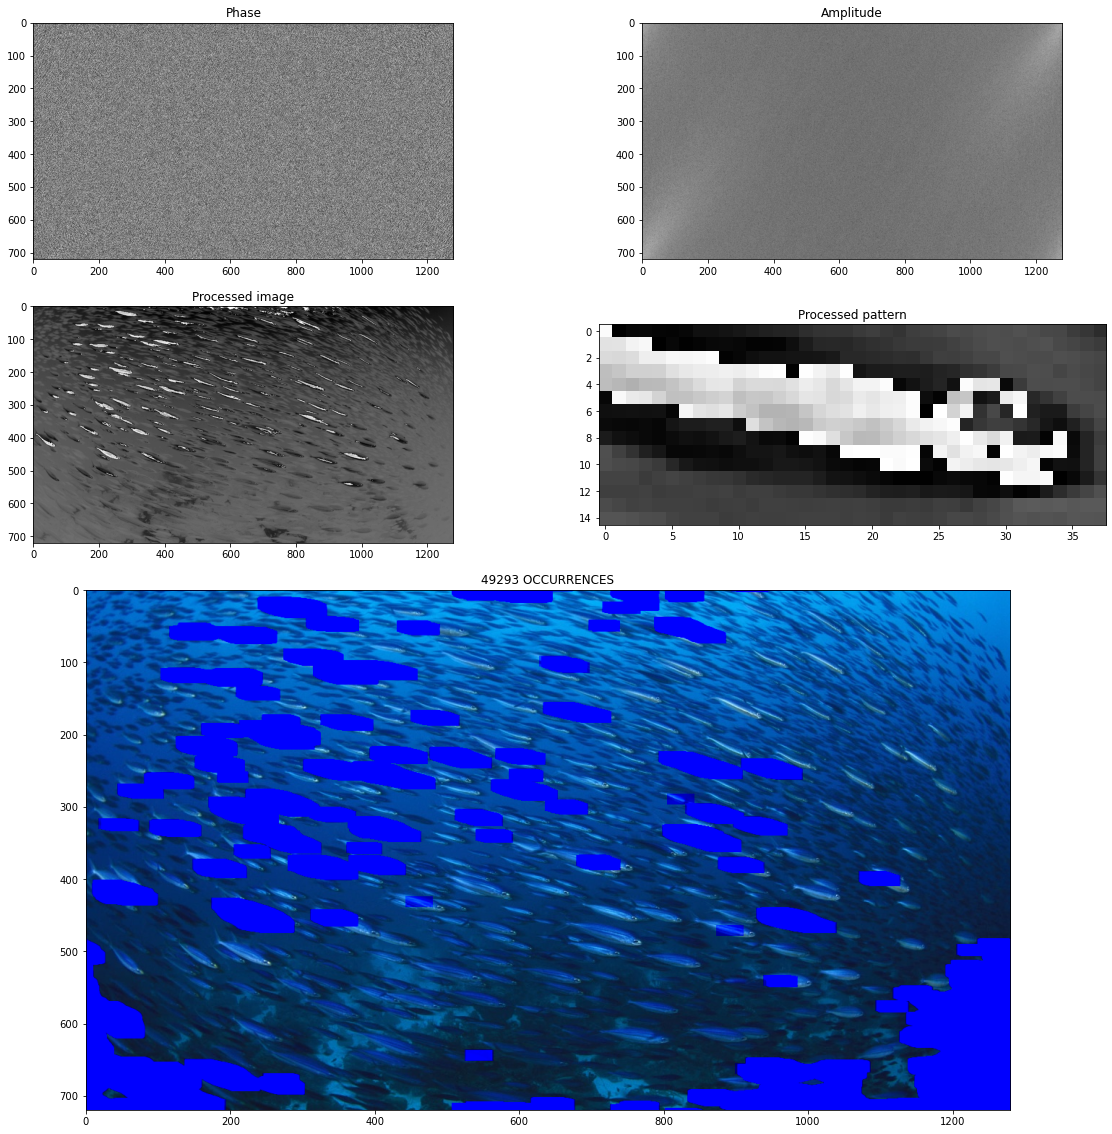

In [37]:
find_patterns('Lab9_school.jpg', 'Lab9_fish1.png', 0.5, extra_val_tranform=125, show_processed=True)

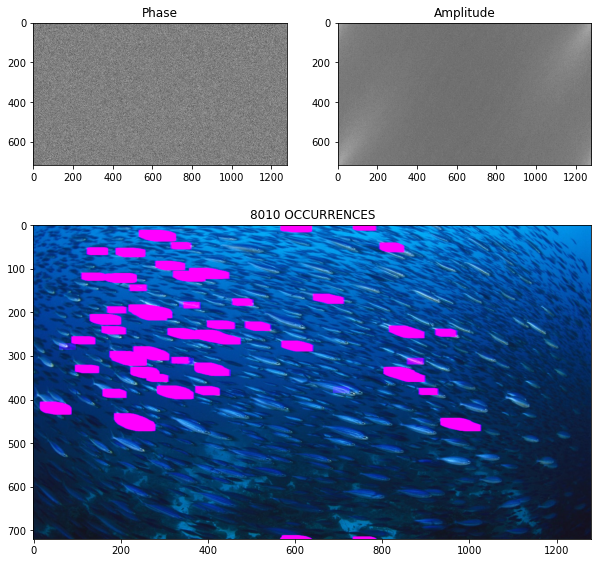

In [38]:
find_patterns('Lab9_school.jpg', 'Lab9_fish1.png', 0.6, extra_val_tranform=125, rgb_diffs=(40,-20,100))


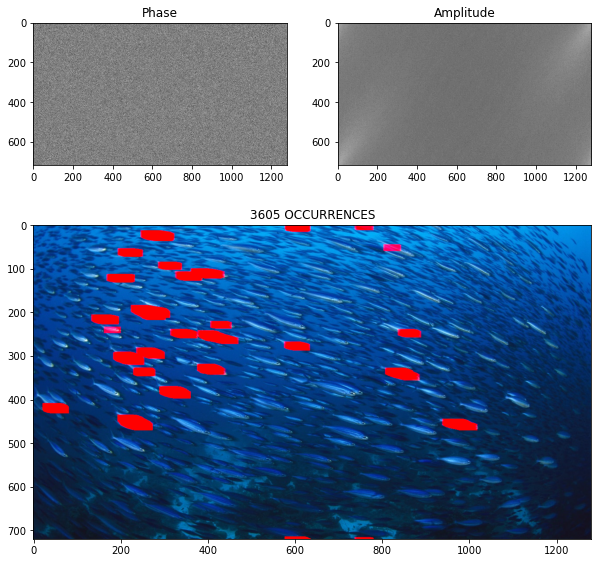

In [39]:
find_patterns('Lab9_school.jpg', 'Lab9_fish1.png', 0.7, extra_val_tranform=125, rgb_diffs=(120,-30,-20))

### Tekst

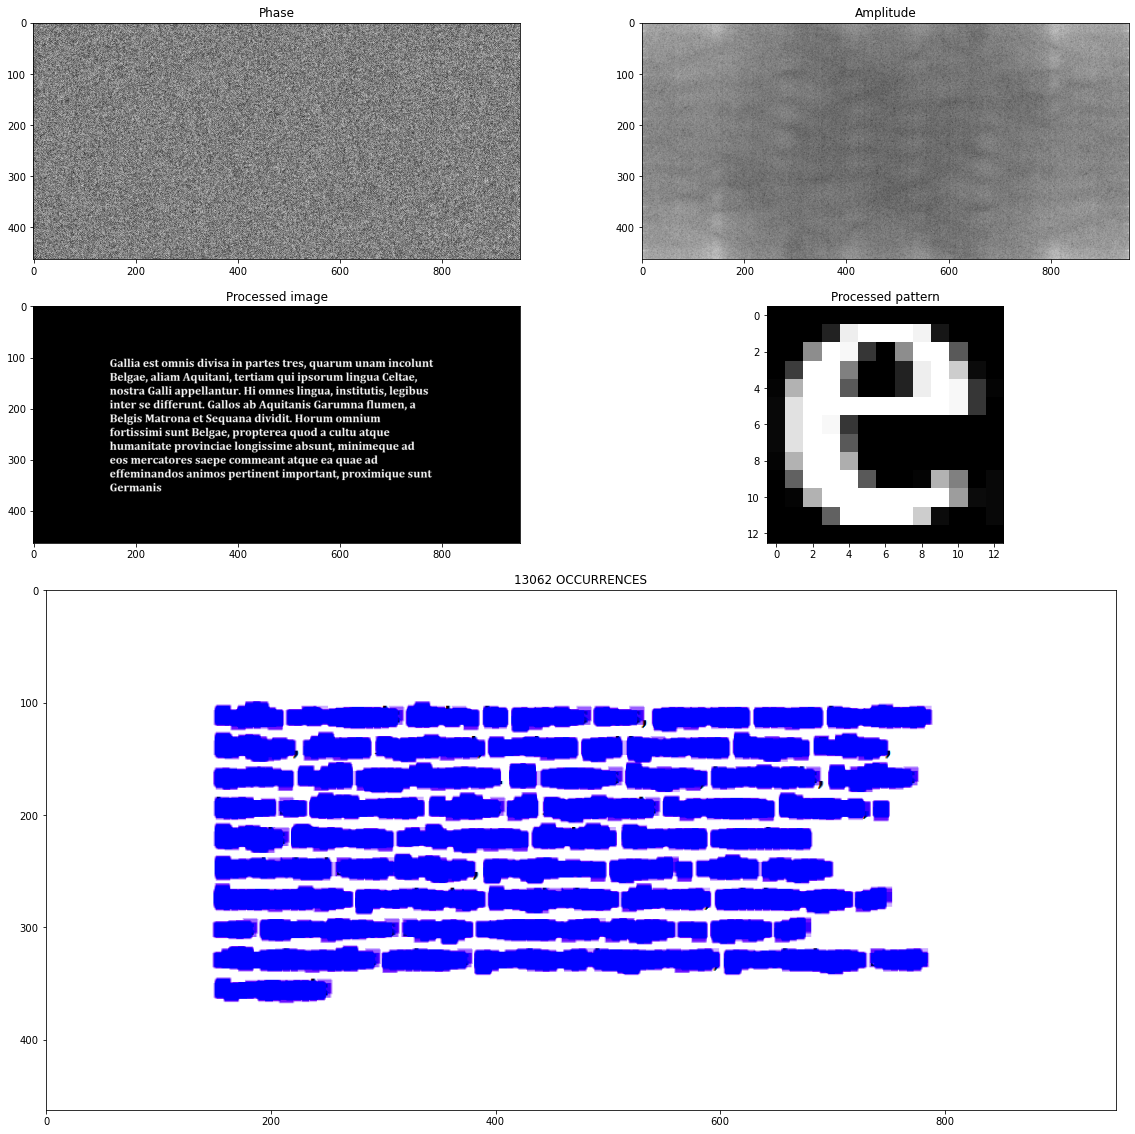

In [40]:
find_patterns('Lab9_galia.png', 'Lab9_galia_e.png', 0.5, show_processed=True)

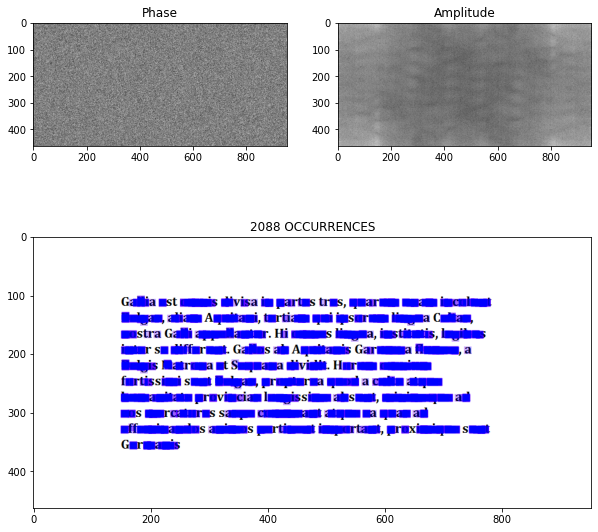

In [41]:
find_patterns('Lab9_galia.png', 'Lab9_galia_e.png', 0.7)

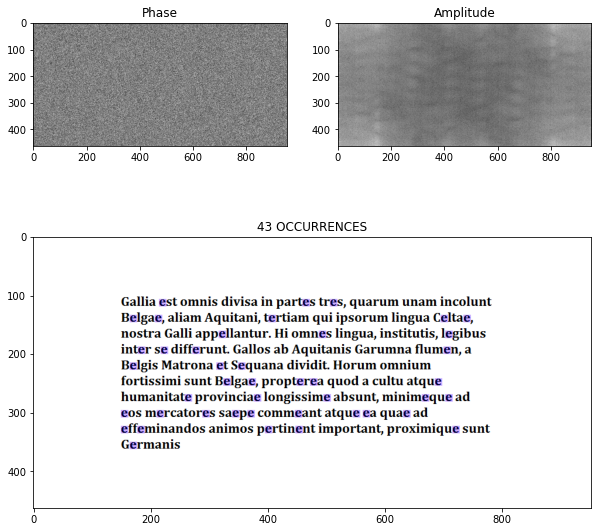

In [42]:
find_patterns('Lab9_galia.png', 'Lab9_galia_e.png', 0.9)

### Wnioski
Dla ławicy ryb:
- zdjęcia należało bardziej skontrastować (`extra_val_tranform`), ponieważ algorytm nie kończył się
- ryby na zdjęciu są pod różnymi kątami oraz zlewają się z tłem, co ma wpływ na wynik algorytmu
Dla tesksu:
- algorytm działa w 100% poprawnie przy doborze odpowieniego parametru

## 2. OCR
Napisz program przekształacajacy obraz w tekst, przyjmujac nastepujace załozenia:
1. Na obrazie znajduje sie tekst złozony z małych liter alfabetu łacinskiego oraz cyfr
2. Na obrazie wystepuje jeden typ i rozmiar czcionki
3. Wez pod uwage czcionki szeryfowe i bezszeryfowe
4. W tekscie wystepuja znaki przestankowe: .,?!
5. Tekst składa sie z wielu linii
6. Tekst moze byc obrócony (krzywo zeskanowany w całosci)
7. Program powinien zwracac tekst wraz ze znakami białymi i znakami nowych linii
8. Program moze raportowac procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczac liczbe wystapien kazdej litery
10. Nalezy zastosowac operacje splotu i DFT albo inne metody (klasyfikacja)
11. Nalezy dokonac redukcji szumu na obrazie wejsciowym

### Generowanie obrazów z tekstem

In [43]:
DATA_DIR = 'ocr_data'
ARIAL_PATH = os.path.join(DATA_DIR, 'arial.ttf')
TIMES_PATH = os.path.join(DATA_DIR, 'times.ttf')
SHORT_TEXT_PATH = os.path.join(DATA_DIR, 'short.txt')
MEDIUM_TEXT_PATH = os.path.join(DATA_DIR, 'medium.txt')
LONG_TEXT_PATH = os.path.join(DATA_DIR, 'long.txt')

def generate_image(textfile_path, filename, font_path='ocr_data\\arial.ttf', font_size=25, line_width=50, margin=10):
    def parse_file_text():
        with open(textfile_path, 'r') as textfile:
            text_lines = textfile.readlines()

        text_lines_wrapped = [textwrap.wrap(line, width=line_width) for line in text_lines]
        processed_text = ''
        for line in text_lines_wrapped:
            if not line:
                processed_text += '\n'

            for wrapped_line in line:
                processed_text += f"{wrapped_line}\n"

        return processed_text

    text = parse_file_text()
    fnt = ImageFont.truetype(font_path, font_size)
    text_sizes = fnt.getsize_multiline(text)
    size = (text_sizes[0] + 2*margin, text_sizes[1] + 2*margin)

    img = Image.new('RGB', size, color = (255, 255, 255))
    d = ImageDraw.Draw(img)
    d.text((margin, margin), text, font=fnt, fill=(0, 0, 0))

    font_name = font_path.split("\\")[-1].split('.')[0].lower()
    filepath = os.path.join(DATA_DIR, f'{filename}_{font_name}.png')
    img.save(filepath)
    img.show()
    return filepath

short_arial_img_path = generate_image(SHORT_TEXT_PATH, 'short', font_path='ocr_data\\arial.ttf')
medium_arial_img_path = generate_image(MEDIUM_TEXT_PATH, 'medium')
long_arial_img_path = generate_image(LONG_TEXT_PATH, 'long')

short_times_img_path = generate_image(SHORT_TEXT_PATH, 'short', font_path=TIMES_PATH)
medium_times_img_path = generate_image(MEDIUM_TEXT_PATH, 'medium', font_path=TIMES_PATH)
long_times_img_path = generate_image(LONG_TEXT_PATH, 'long', font_path=TIMES_PATH)

### OCR

In [44]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,?!'

class MatchCandidate:
    def __init__(self, a,b,c,d):
        self.char = a
        self.C = b
        self.x0 = c
        self.y0 = d

def ocr(im_path, font_name, font_size, C_thresh=1e-5):
    im = Image.open(im_path)
    W, H = im.size

    _, im_processed = process_img(im)
    im_dft = np.fft.fft2(im_processed)

    font = ImageFont.truetype(font_name, font_size)
    match_candidates = []
    char_to_pattern_dims = dict()

    for char in ALPHABET:
        w, h = font.getsize(char)
        char_to_pattern_dims[char] = (w, h)
        pattern = Image.new('RGB', (w, h), color='white')
        ImageDraw.Draw(pattern).text((0, 0), char, font=font, fill='black')
        _, pattern_processed = process_img(pattern)

        max_pattern_C = np.max(np.real(np.fft.ifft2(np.fft.fft2(pattern_processed) * np.fft.fft2(np.rot90(pattern_processed, k=2)))))
        C = np.abs(np.real(np.fft.ifft2(im_dft * np.fft.fft2(np.rot90(pattern_processed, k=2), s=[W, H]))) / max_pattern_C - 1)

        for x in range(W):
            for y in range(H):
                if C[x][y] < C_thresh:
                    x0, y0 = x - w + 1, y - h + 1
                    match_candidates.append(MatchCandidate(char, C[x][y], x0, y0))

    char_w, char_h = font.getsize('i')
    space_w, _ = font.getsize(' ')

    matches = defaultdict(dict)
    for candidate in match_candidates:
        box_x = candidate.x0 // char_w
        box_y = candidate.y0 // char_h
        if box_y not in matches:
            matches[box_y][box_x] = candidate
        elif box_x not in matches[box_y]:
            matches[box_y][box_x] = candidate
        elif candidate.C < matches[box_y][box_x].C:
            matches[box_y][box_x] = candidate

    for box_y in sorted(matches):
        prev_x = -1
        for box_x in sorted(matches[box_y]):
            match = matches[box_y][box_x]
            curr_x = match.x0

            if prev_x != -1 and curr_x - prev_x >= space_w:
                print(' ', end='')
            print(match.char, end='')

            prev_x = curr_x + char_to_pattern_dims[match.char][0]
        print()

### Bezszeryfowe
Użyta czcionka: Arial

In [45]:
ocr(short_arial_img_path, ARIAL_PATH, 25)

Apotem swiat znowu zaczal stniec,ale istnial
zupelne inaczej.
AndrzejSapkowski Ostatnie zyczenie


In [46]:
ocr(medium_arial_img_path, ARIAL_PATH, 25)

Wiadomym jest mi, zemaszlat bliskoczterdziesci,
wygladasz nablisko trzydziesci, wyobrazasz sobie,
zemasznieco ponad dwadziescia, a postepujesz tak
jakbys mial nie ale dziesiec.
AndrzejSapkowski Krew elfow
Apotem swiat znowu zaczal i tniec,ale istnial
zupelne inaczej.
AndrzejSapkowski Ostatnie zyczenie


In [47]:
ocr(long_arial_img_path, ARIAL_PATH, 25)

,
Zle czydobr e,okaze sie pozniej.Ale tr eba
dzialac, smialo chwytaczycie zagrzywe. Wier mi,
malutka,zauje sie wylaczne bezczynnosci,
nezdecydowania, wahania. Czynow idecyzji,choc
nekiedy pr ynosza smuteki zal,nie zalue sie.
AndrzejSapkowski Czaspogardy
Wiadomym jest mi, zemaszlat bliskoczterdziesci,
wygladasz nablisko trzydziesci, wyobrazasz sobie,
zemasznieco ponad dwadziescia, a postepujesz tak
jakbys mial nie ale dziesiec.
AndrzejSapkowski Krew elfow
Apotem swiat znowu zaczal i tniec,ale istnial
zupelne inaczej.
AndrzejSapkowski Ostatnie zyczenie


### Szeryfowe

Użyta czcionka: Times New Roman

In [48]:
ocr(short_times_img_path, TIMES_PATH, 25)

Apotem swiat znowu zaczal istn ec, ale istnial
zupelnie inaczej.
And zejSapkowski, Ostatn e zyczenie


In [49]:
ocr(medium_times_img_path, TIMES_PATH, 25)

Wiadomymjest mi, ze masz lat blisko czterdziesci,
wygladasz na blisko trzyd iesci, wyobrazasz sobie,
ze masz niecoponad dwadziescia, a postepujesz tak
jakbys m al niecale dziesiec.
And zejSapkowski, rew elfow
Apotem swiat znowu zaczal istn ec, ale istnial
zupelnie inaczej.
And zejSapkowski, Ostatn e zyczenie


In [50]:
ocr(long_times_img_path, TIMES_PATH, 25)

Zle czy dobrze, okaze sie pozn ej.Ale trzeba
dzialac, sm alo chw tac zycie zagrzywe. Wierz mi,
malutka, zaluje sie wylaczn e bezczy nosci,
niezdecydowan a, wahan a. Cz now i decyzji, choc
niek edyprzynoszasmuteki zal, nie zaluje sie.
And zejSapkowski, Czas pogardy
Wiadomymjest mi, ze masz lat blisko czterdziesci,
wygladasz na blisko trzyd iesci, wyobrazasz sobie,
ze masz niecoponad dwadziescia, a postepujesz tak
jakbys m al niecale dziesiec.
And zejSapkowski, rew elfow
Apotem swiat znowu zaczal istn ec, ale istnial
zupelnie inaczej.
And zejSapkowski, Ostatn e zyczenie


### Wnioski
Algorytm gubi znaki zarówno dla czcionki szeryfowej jak i bezszeryfowej. Wybór czcionki jak i długości przetwarzanego tekstu wydaje się nie mieć istotnego wpływu na wynik algorytmu - i tak nie zdoła odtworzyć go w 100% poprawnie.